In [183]:
import numpy as np
import scipy
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns
sns.set_style("whitegrid")

In [184]:
def dVdphi(phi):
    """
    Function defining the derivative of the potential, given it's on the 
    form V(phi) = a*phi^2 -b*phi^3 + c*phi^4

    @param phi: our scalar field
    @return The derivative of the potential
    """
    return 2*a*phi -3*b*phi**2 + 4*c*phi**3

In [185]:
def V(phi):
    """
    Function defining the potential, V(phi) = a*phi^2 -b*phi^3 + c*phi^4 
    The parameters a, b, c should be definied s.t we get a 1st order PT, i.e a bump
    Important to only have one bump, and hence only 2 minimas.

    @param phi: our scalar field, should be array
    @return pot: The effective potential
            phiTrueVacuum: The value of phi at the true vacuum
            phiFalseVacuum: The value of phi at the false vacuum
    """
    # The potential
    pot = +a*phi**2 -b*phi**3 + c*phi**4

    # Find the two minima, setting initial guesses at the two endpoints of the span of phi
    phiMin1 = fsolve(dVdphi, phi[0])
    phiMin2 = fsolve(dVdphi, phi[-1])

    # Find the value of the potential at the minimas
    pot1 = +a*phiMin1**2 -b*phiMin1**3 + c*phiMin1**4
    pot2 = +a*phiMin2**2 -b*phiMin2**3 + c*phiMin2**4

    # Check which is the lower minima by comparing the value of the potentials and set the lower one to the true vacuum
    if pot1 < pot2:
        phiTrueVacuum = phiMin1
        phiFalseVacuum = phiMin2
        
        # And the potential at the true and false vacuas
        potTrueVacuum = pot1
        potFalseVacuum = pot2

    else:
        phiTrueVacuum = phiMin2
        phiFalseVacuum = phiMin1
        potTrueVacuum = pot2
        potFalseVacuum = pot1

    return pot, phiTrueVacuum, phiFalseVacuum, potTrueVacuum, potFalseVacuum

In [186]:
def makePlotsPotential(phi_span, potential, phiTrueVacuum, phiFalseVacuum, potTrueVacuum, potFalseVacuum):
    """
    Function to make plots for the potential. One of the potential and one of 
    the inverted potential to visualize the potential for the point particle 
    that we use later on when calculating the bounce. 
     

    @param phi_span: The span of phi, i.e x-axis
           potential: The potential V(phi), i.e y-axis, for every point of phi_span
    @return Two plots in one figure, one of V(phi) and the other -V(phi)
    """

    # ADD POINT OF PHI_F AND PHI_T
    plt.figure()
    ax = plt.subplot(121)
    ax.plot(phi_span, potential, label='$V(\phi)$')
    # ax.plot(phiTrueVacuum, potTrueVacuum, 'o', label='$\phi_T$')
    # txt = '$\phi_T$'
    # ax.annotate(txt, (phiTrueVacuum, potTrueVacuum), xytext=(phiTrueVacuum, potTrueVacuum + 8))
    # ax.plot(phiFalseVacuum, potFalseVacuum, 'o', label='$\phi_F$')
    # txt = '$\phi_F$'
    # ax.annotate(txt, (phiFalseVacuum, potFalseVacuum), xytext=(phiFalseVacuum, potFalseVacuum + 8))
    ax.legend()
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$V(\phi)$')             

    ax = plt.subplot(122)
    ax.plot(phi_span, -potential)
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$- V(\phi)$')

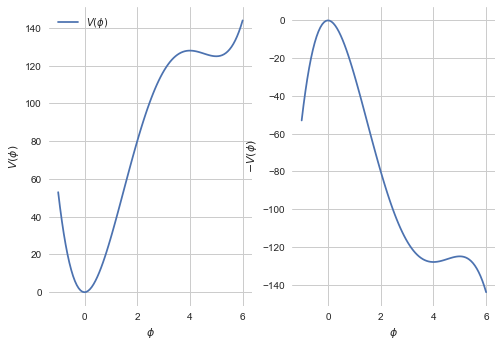

In [187]:
# Set parameters for the potential, V(phi) = a*phi^2 -b*phi^3 + c*phi^4
# Values from AnyBubble article
a = 40
b = 12
c = 1

# Span of phi also from AnyBubble article
phi_span = np.linspace(-1, 6, 100)
potential, phiTrueVacuumAB, phiFalseVacuumAB, potTrueVacuumAB, potFalseVacuumAB = V(phi_span)
makePlotsPotential(phi_span, potential, phiTrueVacuumAB, phiFalseVacuumAB, potTrueVacuumAB, potFalseVacuumAB)

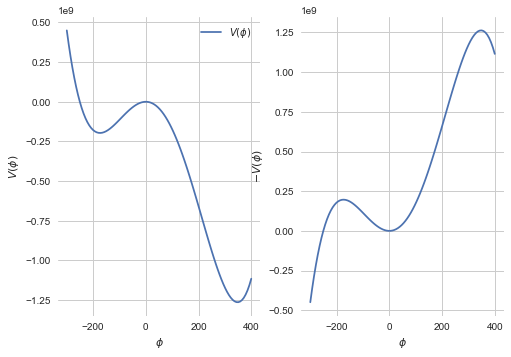

In [188]:
# Set parameters for the potential, V(phi) = a*phi^2 -b*phi^3 + c*phi^4
# Form from Rubakov, values chosen to be SM-like
a = -125**2
b = 30
c = 125**2/(2*246**2)

phi_span = np.linspace(-300, 400, 100)
potential, phiTrueVacuumSM, phiFalseVacuumSM, potTrueVacuumSM, potFalseVacuumSM = V(phi_span)
makePlotsPotential(phi_span, potential, phiTrueVacuumSM, phiFalseVacuumSM, potTrueVacuumSM, potFalseVacuumSM)

In [189]:
def equations(r, y):
    """
    Function setting our equation system from the EOM of the bounce. 
    Turning equation of 2nd order ODE, to system of two 1st order ODEs.

        From: dphi^2/dr^2 + (alpha/r)*dphi/dr = dV/dphi

            introduce v = dphi/dr, s.t dv/dr = dphi^2/dr^2
            and then y = [phi, v], dy/dr = [dphi/dr, dv/dr]

        To: dy/dr = [dphi/dr, dv/dr] = [v, -(alpha/r)*dphi/dr + dV/dphi]                                              

    @param r: For T=0, r = sqrt(t^2 + x^2), for finite T r = r
           y: Array of phi and dphi/dr
           alpha: D-1 term, equals either 3 in 4D or 2 in 3D
    @return dydr: Array of dphi/dr and dphi^2/dr^2
    """
    # Pick out the values from y = [phi, v]
    phi = y[0]
    v = y[1]        # v = dphi/dr

    # When dimension = 4
    alpha = 3

    # Define the derivatives
    dphidr = v
    dvdr = - (alpha/r)*v + dVdphi(phi)      # - (alpha/r)*v is the friction term, dVdphi(phi) the derivative of the potential (-)V(phi)
    
    # Set dy/dr = [dphi/dr, dv/dr]
    dydr = np.array([dphidr, dvdr])
    
    return dydr


In [190]:
def shooting(r, phiTrueVacuum, phiFalseVacuum, undershoot, tol):
    """
    Shooting method to find the bounce solution.

    EOM for the bounce:
        dphi^2/dr^2 = - (alpha/r)*dphi/dr + dV/dphi
    
    Like a point particle moving in a potential -V(phi) subject to a friction term.
    r acts as a time coordinate, and phi the spatial coordinate.

    There are two BCs for the bounce:
        1.) dphi/dr = 0 at r = 0 (no singularities in the origin, starting from rest)
        2.) phi(r) = phi_F at r = infinity  (the particle come at rest in the false vacuum phi_F when r=inf)

    We can turn this BVP to an IVP, we want to find the initial placement of the particle near the true vacuum phi_T that fulfills the BCs.
    We get the ICs:
        1.) dphi/dr = 0 at r = 0
        2.) phi(r) = phi_B at r = 0
    
    Where phi_B is the solution that fulfills BC 2.). 
    Setting dphi/dr = 0 and then an initial placement somewhere close to phi_T we get three different cases:
        a) The particle come at rest at phi_F when r = inf  (right solution, phi_B)
        b) The particle roll past phi_F (overshooting)
        c) The particle does not reach phi_F and experiences damped oscillations around the minimum (undershooting)

    When we have overshooting the initial placement of the particle is too close to phi_T and for undershooting
    it is too far from phi_T and needs to be closer. By trial and error, i.e iterate between over- and undershooting and 
    correct the intial placement until we find the right solution, case a), i.e the bounce solution phi_B.

    @param r: the "time" coordinate
           phiTrueVacuum: The value of phi at the true vacuum
           phiFalseVacuum: The value of phi at the false vacuum
           undershoot: sets the initial placement of the particle s.t we get an undershoot by phiTrueVacuum + undershoot.
           tol: Set tolerance for which we accept our numerical solution
    @return y_num: The numerical solution of the bounce

    """
    
    # Set tolerance for which we accept our numerical solution
    # and a maximum of iteration to abrupt the while loop 
    #tol = 1e-3
    max_iters = 100

    # If the inparameter 'undershoot' is None we estimate the parameter
    # Does not work atm. 
    # if undershoot is None:
    #     undershoot = (phiFalseVacuum - phiTrueVacuum)/4

    # When phi_T is placed to the right of phi_F
    if phiTrueVacuum > phiFalseVacuum:
        # Set a lower and higher bound for our initial placement of the particle. 
        # Should be choosen s.t high gives an overshoot and low an undershoot.
        high = phiTrueVacuum
        low = phiTrueVacuum - undershoot

    # When phi_T is placed to the left of phi_F
    elif phiTrueVacuum < phiFalseVacuum:
        # Set a lower and higher bound for our initial placement of the particle. 
        # Should be choosen s.t high gives an undershoot and low an overrshoot.
        high = phiTrueVacuum + undershoot
        low = phiTrueVacuum

    print('phi_T = ', phiTrueVacuum, 'phi_F = ', phiFalseVacuum)
    
    # BC 1.), dphi/dr = 0 at r = 0
    dphidr0 = 0

    # Count of iterations
    count = 0

    # Parameter needed for solve_ivp, the first and last value of r
    xspan = (r[0], r[-1])

    while count <= max_iters:
        count = count + 1

        # Set the intial guess of the placement, phi0, as the mean between over- and undershoot              
        phi0 = np.mean([low, high])

        # Collect the two initial conditions
        f0 = [phi0, dphidr0]

        # Solve our system of ODEs given as an IVP, evaluated at every point in r 
        sol = solve_ivp(equations, xspan, f0, t_eval = r)
        print(sol.message)      

        # The numerical solution from the solver
        y_num = sol.y[0, :]

        # Felsök
        print('low =', low, ', high = ', high, ', Initial guess: ', phi0)
        print('count: ', count, ', Value of last point in numerical: ', y_num[-1], ', False vacuum: ', phiFalseVacuum)

        # If the initial placement was right, i.e phi0 = phi_B we have found our solution and break
        # the while loop. check if value of the last point in our numerical solution is within tolerance to phi_F.
        if np.abs(y_num[-1] - phiFalseVacuum) <= tol:      
            break
        
        # If the solution is not at the false vacuum we have either an over- or undershoot and 
        # we need to adjust our bounds. Depending on if phi_F is either to the righ or the left 
        # of phi_T the conditions for over- and undershoot will look different.

        # When phi_T is placed to the right of phi_F
        if phiTrueVacuum > phiFalseVacuum:
            # We get an overshoot if the last point of y_num is smaller than phi_F or if
            # it goes to +/- inf, we get the message 'Required step size is less than spacing between numbers.'
            # from solv_ivp if it has very high or low values since it stops working
            if sol.message == 'Required step size is less than spacing between numbers.'\
                or y_num[-1] < phiFalseVacuum or y_num[-1] > phiTrueVacuum:
                high = phi0
                print('Overshoot \n')

            # elif sol.message == 'Required step size is less than spacing between numbers.':
            #     high = high -0.1
            #     print('Kaos \n')

            # In all the other cases we have an undershoot                  
            else:                           
                low = phi0
                print('Undershoot \n')  

        # When phi_T is placed to the left of phi_F
        elif phiTrueVacuum < phiFalseVacuum:
            # We get an overshoot if the last point of y_num is bigger than phi_F or if
            # it goes to +/- inf, we get the message 'Required step size is less than spacing between numbers.'
            # from solv_ivp if it has very high or low values since it stops working
            if sol.message == 'Required step size is less than spacing between numbers.'\
                or y_num[-1] < phiTrueVacuum or y_num[-1] > phiFalseVacuum:
                low = phi0
                print('Overshoot \n')

            # In all the other cases we have an undershoot
            # Fix condition                  
            else:                           
                high = phi0
                print('Undershoot \n')

        # Get dphi_B/dr needed for the Euclidean action
        dPhiB = sol.y[1, :]
    return y_num, dPhiB

In [191]:
def plotBounce(phi_Bnum, r, phiTrueVacuum, phiFalseVacuum):
    plt.figure()
    plt.plot(r, phi_Bnum, label = '$\phi_B$')
    plt.plot([r[0], r[-1]], [phiFalseVacuum, phiFalseVacuum], '--', label = '$\phi_F$')
    plt.plot([r[0], r[-1]], [phiTrueVacuum, phiTrueVacuum], '--', label = '$\phi_T$')
    plt.legend()
    plt.xlabel('r')
    plt.ylabel('$\phi_B$(r)') 

phi_T =  0 phi_F =  5
The solver successfully reached the end of the integration interval.
low = 0 , high =  2 , Initial guess:  1.0
count:  1 , Value of last point in numerical:  3.953614303075183 , False vacuum:  5
Undershoot 

The solver successfully reached the end of the integration interval.
low = 0 , high =  1.0 , Initial guess:  0.5
count:  2 , Value of last point in numerical:  3.9091291335087215 , False vacuum:  5
Undershoot 

Required step size is less than spacing between numbers.
low = 0 , high =  0.5 , Initial guess:  0.25
count:  3 , Value of last point in numerical:  30.121258997818725 , False vacuum:  5
Overshoot 

Required step size is less than spacing between numbers.
low = 0.25 , high =  0.5 , Initial guess:  0.375
count:  4 , Value of last point in numerical:  714.667320661644 , False vacuum:  5
Overshoot 

The solver successfully reached the end of the integration interval.
low = 0.375 , high =  0.5 , Initial guess:  0.4375
count:  5 , Value of last point in nume

Text(0, 0.5, '$\\phi_B$(r)')

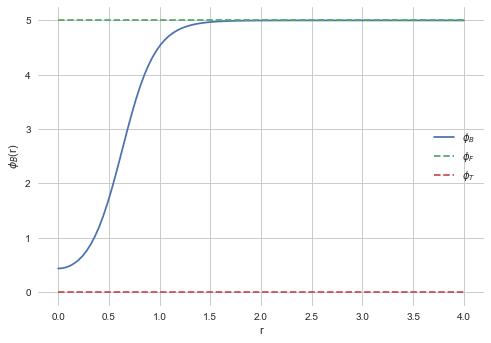

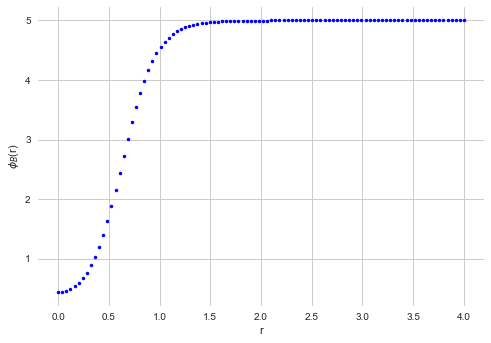

In [193]:
# Set the same values as above for the V(phi) = 40*phi^2 -12*phi^3 + phi^4, AnyBubble
a = 40
b = 12
c = 1

phi_span = np.linspace(-1, 6, 100)
potential, phiTrueVacuumAB, phiFalseVacuumAB, potTrueVacuumAB, potFalseVacuumAB = V(phi_span)
phiFalseVacuumAB = 5
phiTrueVacuumAB = 0

# First value of r should be close to but not equal 0 since we divide by 0 in EOM
r = np.linspace(0.00001, 4, 100)

# Use the shooting method to find the bounce solution
phiB_num, dPhiB_num = shooting(r, phiTrueVacuumAB, phiFalseVacuumAB, undershoot = 2, tol = 1e-3)
plotBounce(phiB_num, r, phiTrueVacuumAB, phiFalseVacuumAB)
plt.figure()
plt.plot(r, phiB_num, 'b.')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')            

phi_T =  [348.12179281] phi_F =  [-173.83571281]
The solver successfully reached the end of the integration interval.
low = [338.12179281] , high =  [348.12179281] , Initial guess:  343.1217928141747
count:  1 , Value of last point in numerical:  -13.568810090528025 , False vacuum:  [-173.83571281]
Undershoot 

The solver successfully reached the end of the integration interval.
low = 343.1217928141747 , high =  [348.12179281] , Initial guess:  [345.62179281]
count:  2 , Value of last point in numerical:  -4.56017552260523 , False vacuum:  [-173.83571281]
Undershoot 

The solver successfully reached the end of the integration interval.
low = [345.62179281] , high =  [348.12179281] , Initial guess:  346.8717928141747
count:  3 , Value of last point in numerical:  24.94356767703184 , False vacuum:  [-173.83571281]
Undershoot 



C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\integrate\_ivp\base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)


Required step size is less than spacing between numbers.
low = 346.8717928141747 , high =  [348.12179281] , Initial guess:  [347.49679281]
count:  4 , Value of last point in numerical:  -9424.59712245947 , False vacuum:  [-173.83571281]
Overshoot 

Required step size is less than spacing between numbers.
low = 346.8717928141747 , high =  [347.49679281] , Initial guess:  [347.18429281]
count:  5 , Value of last point in numerical:  -1576.7879626969388 , False vacuum:  [-173.83571281]
Overshoot 

The solver successfully reached the end of the integration interval.
low = 346.8717928141747 , high =  [347.18429281] , Initial guess:  [347.02804281]
count:  6 , Value of last point in numerical:  18.186014933879093 , False vacuum:  [-173.83571281]
Undershoot 

The solver successfully reached the end of the integration interval.
low = [347.02804281] , high =  [347.18429281] , Initial guess:  347.1061678141747
count:  7 , Value of last point in numerical:  -37.382679530722804 , False vacuum:  [-

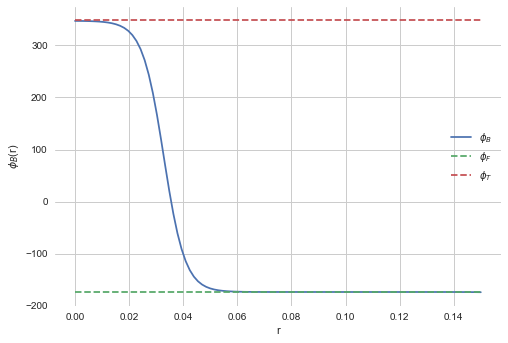

In [194]:
# Set the same values as above for the V(phi) = a*phi^2 -b*phi^3 + c*phi^4, Rubakov, SM-like
a = -125**2
b = 30
c = 125**2/(2*246**2)

phi_span = np.linspace(-300, 400, 100)
potential, phiTrueVacuumSM, phiFalseVacuumSM, potTrueVacuumSM, potFalseVacuumSM = V(phi_span)

# Supersensitive to end value of r, if too big it will roll back and be an undershoot
# not consistent with BCs?? To see this put 0.2 or more
# First value should be close to but not equal 0 since we divide by 0 in EOM
r = np.linspace(0.00001, 0.15, 100)

# Use the shooting method to find the bounce solution
phi_Bnum, dPhiB_num = shooting(r, phiTrueVacuumSM, phiFalseVacuumSM, undershoot = 10, tol = 1)
plotBounce(phi_Bnum, r, phiTrueVacuumSM, phiFalseVacuumSM)


phi_T =  1 phi_F =  0
The solver successfully reached the end of the integration interval.
low = 0.85 , high =  1 , Initial guess:  0.925
count:  1 , Value of last point in numerical:  0.37002506458547885 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 0.925 , high =  1 , Initial guess:  0.9625
count:  2 , Value of last point in numerical:  0.3531378152111351 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 0.9625 , high =  1 , Initial guess:  0.98125
count:  3 , Value of last point in numerical:  0.32541631742846466 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 0.98125 , high =  1 , Initial guess:  0.990625
count:  4 , Value of last point in numerical:  0.2974026548070256 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 0.990625 , high =  1 , Initial gu

Text(0, 0.5, '$\\phi_B$(r)')

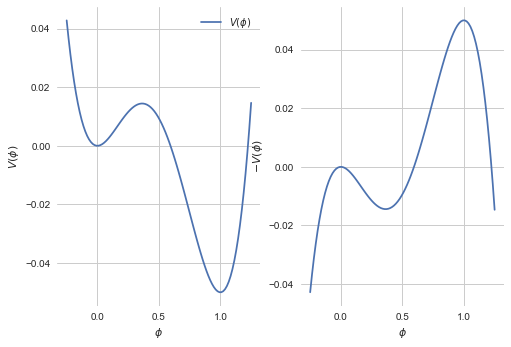

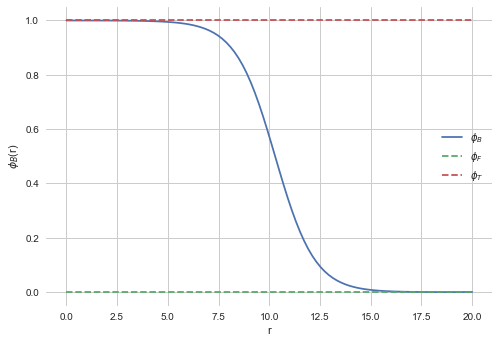

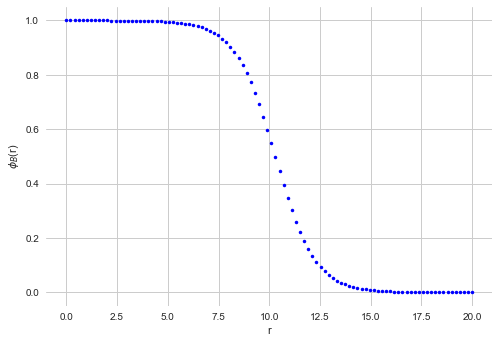

In [195]:
# Shifted potential, V(chi) = (-4*alpha + 3)/2*chi**2 -chi**3 + alpha*chi**4, alpha = c*abs((phi_T - phi_F)/(b + 4cphi_f))
# compared to V(phi) = a*phi^2 +b*phi^3 + c*phi^4 and phi_T = 1, phi_F = 0

# LÄGG TILL FOR-LOOP MED ALPHA
# require 0.5 < alpha < 0.75
alpha = 0.55

a = (-4*alpha + 3)/2
b = 1
c = alpha

chi_span = np.linspace(-0.25, 1.25, 100)
potential, phiTrueVacuumS, phiFalseVacuumS, potTrueVacuumS, potFalseVacuumS = V(chi_span)
phiTrueVacuumS = 1
phiFalseVacuumS = 0
makePlotsPotential(chi_span, potential, phiTrueVacuumS, phiFalseVacuumS, potTrueVacuumS, potFalseVacuumS)

# First value of r should be close to but not equal 0 since we divide by 0 in EOM
r = np.linspace(0.00001, 20, 100)

# Use the shooting method to find the bounce solution
phi_Bnum, dPhiB_num = shooting(r, phiTrueVacuumS, phiFalseVacuumS, undershoot = 0.15, tol = 1e-3)
plotBounce(phi_Bnum, r, phiTrueVacuumS, phiFalseVacuumS)
plt.figure()
plt.plot(r, phi_Bnum, 'b.')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
